<a href="https://colab.research.google.com/github/yexf308/AppliedStatistics/blob/main/11_Ensemble_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
import pandas as pd
from scipy import linalg
from itertools import combinations
import scipy

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$


This notebook is based on Eric Eaton's slides and Hands on Machine learning textbook. 

# Ensemble Learning
- Suppose you pose a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer. This is called the **wisdom of the crowd**. S

- Similarly, if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. 

- A group of predictors is called an **ensemble**; thus, this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an **Ensemble method**.


Consider a set of classifiers $h_1, h_2,\dots, h_L$.
**Idea**: Construct a classifier $H(\mathbf{x})$ that combines the
individual decisions of $h_1, h_2, \dots, h_L$. 

- Could have the member classifiers vote, such as majority rule. 

- Could use different members for different regions of the
instance space (based on the performance). 

- Even if each classifier is a **weak learner**
(meaning it does only slightly better than random guessing), the ensemble can still be
a **strong learner** (achieving high accuracy), provided there are a sufficient number of
weak learners in the ensemble, and they are sufficiently diverse.

Successful ensembles require **diversity**,

- Classifiers should make different mistakes.

- Can have different types of base learners. 
- We should train the dataset using very different algorithms. 

## Voting classifiers
### 1. Combining Classifiers: Averaging
Simple majority rule/uniform averaging. 

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/ensemble1.png?raw=true" width="400" />

### 2. Combining Classifiers: Weighted Average
Coefficients of individual members are trained using
a validation set. Or if all classifiers are able to estimate class probabilities, you can averaged over all the individual classifier by giving more weight to highly confident votes. 

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/ensemble2.png?raw=true" width="400" />

### 3. Combining Classifiers: Gating
Coefficients of individual members depend on input and train gating function via validation set. 

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/ensemble3.png?raw=true" width="400" />

### 4. Combining Classifiers: Stacking

Predictions of 1st layer used as input to 2nd layer and train 2nd layer on validation set.

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/ensemble4.png?raw=true" width="400" />


In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

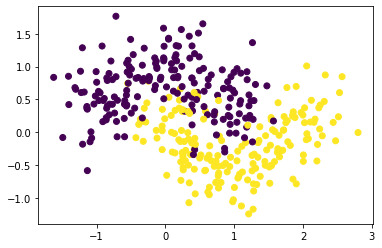

In [4]:
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

In [5]:
# approach 1: Hard voting
voting_clf = VotingClassifier(
estimators=[('lr', LogisticRegression(random_state=42)),
('rf', RandomForestClassifier(random_state=42)),
('svc', SVC(random_state=42))
]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [7]:
voting_clf.predict(X_test[:1])

array([1])

In [8]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [9]:
voting_clf.score(X_test, y_test)

0.912

In [10]:
# approach 2: soft voting
# the SVC class by default the predict_proba function is set to false. 
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Random Forest
- **Bagging**(bootstrap aggregating). Averaged trees trained
on bootstrapped datasets that
used all $p$ variables.

- **Random Forest**: Averaged trees
trained on bootstrapped datasets
that used $m< p$ random variables.


Both methods are  **low bias, low variance**. But random forests have greater tree diversity, which (again) trades a higher bias for a lower variance,
generally yielding an overall better model.

Remember the decision tree can be easily overfitted, but has low bias. The idea of random forest is to reduce variance by
construct a lot of “lightly correlated”
trees and average them. 


### Random Forest Algorithm for Classification/Regression
### Training
We will constrict $B$ decision trees. 

For $b=1$ to $B$:
- Draw a bootstrap sample $\m{Z}^*$ of size $N$ from the training data (sampling $N$ instances with replacement).  

- Grow a random forest tree $T_b$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of tree, until the minimum node size $n_\min$ is reached. 
  - Select $m$ features at random from $p$ features. (for regression, $m=\min(5, \lfloor p/3 \rfloor)$ and for classification, $m=\lfloor \sqrt{p}\rfloor$). **If we select all $p$ features, this becomes "bagging"!**
  - Pick the best variable/split point among $m$ features. 
  - Split the node into two sibling nodes. 

- Output the ensemble of trees $\{T_b\}_{b=1}^B$. 



Note: With this bootstrapping process, it can be shown **mathematically** that only
about 63% of the training instances are sampled on average for each decision tree.  The
remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. These oob instances are automatically becomes validation set. 

### Prediction
At a new point $\m{x}$,

- **Regression:** $\hat{f}_{rf}^B(\m{x})= \frac{1}{B}\sum_{b=1}^B T_b(\m{x}) $. 

- **Classification:** Let $\hat{C}_b(\m{x})$ be the class prediction of $b$th random forest tree, then $\hat{C}_{rf}^B(\m{x})= \text{majority}\{\hat{C}_b(\m{x})\}_{b=1}^B$. 


<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/rf.png?raw=true" width="600" />


A  bit theory here, 
given $Y_1, \dots, Y_B$ with the same mean $\mu$ and the same variance $\sigma^2$, but they are all weakly correlated (i.e., they are not independent), $\mb{E}[(Y_i-\mu)(Y_j-\mu)]= \rho \sigma^2$. 

So $\mb{E}[(\frac{1}{B}\sum_{i=1}^B Y_i-\mu)^2]=?$


## Bagging
One can implement bagging/random forest by yourself. 

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# 500 Decision Tree classifiers
# 100 training instances
# n_jobs=-1 to use all cores. 
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [13]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

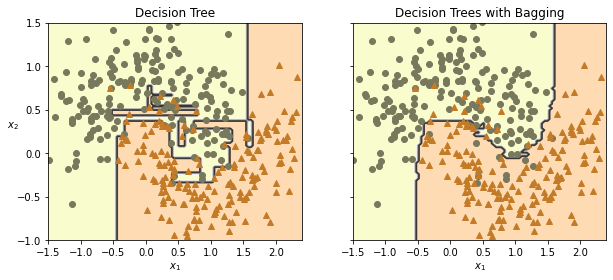

In [15]:
# compare with decision tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

## Out of bag evaluation

In [17]:
# automatic oob evaluation after training.
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,max_samples =100,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9253333333333333

Compare with test dataset. 

In [18]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)
# validation accuracy is 0.925
# testing accuracy is 0.904

0.904

## Random forest
Usually `max_samples` is the same as training samples. It samples $\sqrt{p}$ features. 


In [20]:
from sklearn.ensemble import RandomForestClassifier
# each tree is limited to maximum 16 nodes
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

In [ ]:
# one can use bag_clf to rewrite random forest
bag_clf2 = BaggingClassifier(
DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
n_estimators=500, n_jobs=-1, random_state=42)

# Boosting and Additive Models
Can weak learners be combined to create a strong learner? 

**Weak Learner:**An algorithm $\c{A}$ is a weak learner for a hypothesis class $\c{H}$ that maps $X$ to
${−1, 1}$ if for all input distributions over $X$ and $h\in \c{H}$, we have that A correctly classifies $h$ with error at most $1/2 − \gamma$. 

It is possible! **AdaBoost!**

Let's think this problem naively. 

- **Setup:** $\c{D}=\{\m{x}^{(i)}, y^{(i)}\}_{i=1}^N, \m{x}\in \mb{R}^D, y\in \{+1, -1\}$. 

- **Generate some classifers:** $\phi_t: \mb{R}^D\rightarrow \mb{R}, t=1,\dots, p$.

- Learning weights: $\hat{\mm{\beta}} = \arg\min_{\mm\beta}\sum_{i=1}^N\ell(y^{(i)},\sum_{t=1}^T \beta_t \phi_t(\m{x}^{(i)}))$.

- Prediction on new data: $f(\m{x})= \text{sign}(\sum_{t=1}^T \hat{\beta}_t \phi_t(\m{x}))$. So each classifiers are assigned some weight $\beta_t$. 

But how to find best classifiers. Note thw following optimization is computational hard, 
$$\hat{\mm{\beta}}, \hat{\phi}_t = \arg\min_{\mm{\beta}, \phi_t} \sum_{i=1}^N\ell(y^{(i)},\sum_{t=1}^T \beta_t \phi_t(\m{x}^{(i)})), \qquad t = 1,\dots, T. $$




---


## AdaBoost 

AdaBoost is an algorithm for constructing a ”strong” classifier as linear combination $h(\m{x}) = \sum_{t=1}^T \hat{\beta}_t \phi_t(\m{x}) $ of “simple” “weak” classifiers $\phi_t(\m{x})$. 

- $\phi_t(\m{x})$: “weak” classifiers/features (can be decision tree/perceptron/logistic regression). Typically, the space $\c{H} = \text{span}\{\phi_t\}$ is infinite dimensional. 
- $f(\m{x})= \text{sign}(h(\m{x}))$: ‘’strong” classifier. 

### Algorithm

- Initialize a vector of $N$ uniform vector $\m{w}_1 = \bcm \frac{1}{N} & \dots & \frac{1}{N} \ecm $. 

- For $t=1,\dots, T$: 
  - Train classifier $\phi_t$ on the training dataset $\c{D}$ with weights $\m{w}_t$ that minimize the weighted error. 
  - Compute the weighted training error of $\phi_t$, $\epsilon_t = \sum_{i=1}^N \m{w}_t(i)\mb{1}_{y^{(i)}\ne \phi_t(\m{x}^{(i)}) }$. If $\epsilon_t> 1/2$, stop the loop. 

  - Choose $\beta_t = \frac{1}{2}\ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$. Update the all instance weights, 
   \begin{align}
   \m{w}_{t+1}(i) = \m{w}_t(i)\exp(-\beta_t y^{(i)}\phi_t(\m{x}^{(i)}))
   \end{align}

 - Normalize $\m{w}_{t+1}$ to be a distribution.   

- Return the strong classifier $f(\m{x})=\text{sign}(\sum_{t=1}^T \beta_t \phi_t(\m{x}))$



Note: 
- $\beta_t$ measures the importance of $\phi_t$. If $\epsilon_t\ge 0.5$, then $\beta_t\ge 0$ ($\beta_t$ grows $\epsilon_t$ gets smaller.)


- Weight of correct predictions are multiplied by $\exp(-\beta_t)\le 1$. 

- Weight of incorrect predictions are multiplied by $\exp(\beta_t)\ge 1$. 


- For algorithms like logistic regression, can simply
incorporate weights $\m{w}_t$ into the cost function.  Essentially, weigh the cost of misclassification differently
for each instance, 
\begin{align}
J_{\text{reg}}(\mm\theta) = -\sum_{i=1}^N \m{w}_t(i)\left[y^{(i)}\log \phi_t(\m{x}^{(i)};\mm\theta) + (1-y^{(i)})\log (1- \phi_t(\m{x}^{(i)};\mm\theta) )\right] + \lambda \|\mm\theta\|_2^2
\end{align}

- For algorithms like decision tree, can use `sample_weight` as the input. 

- For algorithms that don’t directly support instance
weights, use weighted bootstrap sampling, i.e., form training set by resampling instances with
replacement according to $\m{w}_t$.



### Benchmark Example
Size of points represents the instance's weight. We want to build a model to distinguish red and blue points. 

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB1.png?raw=true" width="300" />

At $t=1$,

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB2.png?raw=true" width="300" />
<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB3.png?raw=true" width="300" />


At $t=2$,

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB5.png?raw=true" width="300" />
<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB6.png?raw=true" width="300" />


At $t=3$,

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB7.png?raw=true" width="300" />
<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB8.png?raw=true" width="300" />

At $t=4$,

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB9.png?raw=true" width="300" />
<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB10.png?raw=true" width="300" />

At $t=T$,

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB11.png?raw=true" width="300" />
<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/AB12.png?raw=true" width="300" />